# Create sentiment table

In [1]:
import pandas as pd
import numpy as np
from gensim.models import Word2Vec
from sklearn.cluster import KMeans
from pythainlp import word_vector

In [2]:
word_vectors = word_vector.get_model()
#word_vectors.vectors

# Choose best cluster number

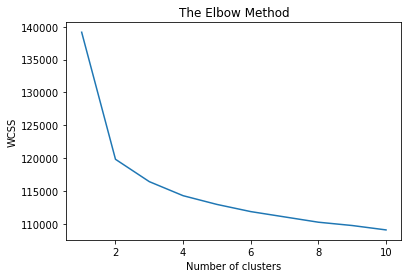

In [4]:
import matplotlib.pyplot as plt
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters = i, init = 'k-means++', random_state = 42)
    kmeans.fit(np.array(word_vectors.vectors))
    wcss.append(kmeans.inertia_)
plt.plot(range(1, 11), wcss)
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

In [36]:
kmeans = KMeans(n_clusters=4, max_iter=1000, random_state=True, n_init=50)
y = kmeans.fit_predict(np.array(word_vectors.vectors))

In [37]:
wordsAmount = word_vectors.vectors.shape[0]
words = word_vectors.vocab.keys()

In [38]:
#check if the order of vectors are the same
#word_vectors.vectors to train model => cluster labels same order
checkTrue = True

for i,key in zip(range(wordsAmount), words):
    checkTrue = (word_vectors[key] == word_vectors.vectors[i]).all() and checkTrue
    
print(checkTrue)

True


In [56]:
print(word_vectors.similar_by_vector(kmeans.cluster_centers_[2], topn=20, restrict_vocab=None))
kmeans.cluster_centers_
print(kmeans.transform([kmeans.cluster_centers_[2]]))
print(kmeans.transform([kmeans.cluster_centers_[1]]))
print(kmeans.transform([kmeans.cluster_centers_[0]]))

[('ในเวลานั้น', 0.5669651031494141), ('เป็นครั้งคราว', 0.5531692504882812), ('เสมอมา', 0.5510373711585999), ('โดยตลอด', 0.5454616546630859), ('อย่างถาวร', 0.5441012382507324), ('ในเวลาเดียวกัน', 0.5367333889007568), ('เป็นสำคัญ', 0.5332139730453491), ('เป็นการชั่วคราว', 0.5311963558197021), ('โดยทันที', 0.5277149677276611), ('ในไม่ช้า', 0.5243468880653381), ('ภายในบ้าน', 0.51945561170578), ('ทั้งมวล', 0.5194107890129089), ('จวบจน', 0.519090473651886), ('อย่างเปิดเผย', 0.5182290077209473), ('สืบไป', 0.5175905823707581), ('อย่างแท้จริง', 0.5166891813278198), ('โดยพฤตินัย', 0.5112501382827759), ('เมื่อไม่นานมานี้', 0.5093095898628235), ('ทั้งนั้น', 0.5074727535247803), ('อย่างแน่นอน', 0.5058451890945435)]
[[1.44069429 1.71917265 0.         0.90939345]]
[[0.92625727 0.         1.71917265 1.3919225 ]]
[[0.         0.92625727 1.44069429 0.89732851]]


In [160]:
positive_cluster_center = kmeans.cluster_centers_[0]
negative_cluster_center = kmeans.cluster_centers_[1]

In [48]:
kmeans.transform([word_vectors['ไม่']])

array([[5.68301196, 5.76651374, 5.41116997, 5.55259009]])

In [49]:
df = pd.DataFrame(word_vectors.vocab.keys(),columns=['words'])
df['vectors'] = df.words.apply(lambda x: word_vectors[x])
df['clusters']=y

def convertValue():
    clusterValue = []
    for i in df.clusters:
        if i==2:
            clusterValue.append(1)
        elif i==3:
            clusterValue.append(-1)
        else:
            clusterValue.append(0)
    return clusterValue

df['cluster_value'] = convertValue()
df['closeness_score'] = df.apply(lambda x: 1/(kmeans.transform([x.vectors]).min()), axis=1)

In [50]:
df['sentiment_coeff'] = df.closeness_score * df.cluster_value
df[['words', 'sentiment_coeff']].to_csv('sentiment_dictionary.csv', index=False)

In [53]:
df[df.cluster_value==1]

,words,vectors,clusters,cluster_value,closeness_score,sentiment_coeff
0,ที่,"[0.308956, -0.097699, 0.116745, 0.215612, 0.01...",2,1,0.134187,0.134187
1,และ,"[0.010751, -0.618971, 0.129665, 0.03546, -0.00...",2,1,0.143851,0.143851
2,เป็น,"[-0.015736, -0.258926, 0.052953, 0.153728, -0....",2,1,0.169270,0.169270
3,ของ,"[-0.189711, -0.174774, 0.171124, -0.186771, 0....",2,1,0.131872,0.131872
4,มี,"[-0.156962, -0.231863, 0.080312, 0.323157, 0.2...",2,1,0.174364,0.174364
...,...,...,...,...,...,...
8386,ตัดผ่าน,"[-0.047419, 0.027557, -0.039753, -0.02959, 0.0...",2,1,0.479218,0.479218
8573,อย่างแน่นอน,"[-0.060258, -0.054829, 0.065596, -0.078258, -0...",2,1,0.559882,0.559882
9032,"""?""""""","[-0.151507, -0.1178, 0.100134, 0.050755, -0.08...",2,1,0.392288,0.392288
9388,อีกแล้ว,"[0.062126, -0.049788, 0.089085, -0.023851, -0....",2,1,0.505368,0.505368


# Predict Sentiment of a sentence

In [54]:
def predictsentiment(sent):
    print(sent)
    #tokenize sentence using thainlp
    
    from pythainlp.tokenize import word_tokenize
    sent_arr = word_tokenize(sent , engine = 'pyicu')
    print(sent_arr)
    
    sentiment = 0
    sentiment_df = pd.read_csv('sentiment_dictionary.csv')
    for word in sent_arr:
        if len(sentiment_df[sentiment_df.words==word])!=0:
            sentiment += sentiment_df[sentiment_df.words==word].values[0][1]
            print(sentiment_df[sentiment_df.words==word].values[0][1])
    print(sent,'มีค่าเป็น:', sentiment)

In [55]:
predictsentiment('สินค้าไม่ได้เรื่อง')

สินค้าไม่ได้เรื่อง
['สินค้า', 'ไม่ได้เรื่อง']
0.2588045320515311
0.0
สินค้าไม่ได้เรื่อง มีค่าเป็น: 0.2588045320515311


# Array stuff

In [63]:
x = np.array([1,0,2,0,3,0,4,5,6,7,8])
np.where(x == 0)
np.nonzero(y)[0][:100]

100

In [35]:
#select vectors[position is true]
print(word_vectors.vectors.shape[0] == word_vectors.vectors[y==1].shape[0] + word_vectors.vectors[y==0].shape[0])

True


# See which cluster is negative or positive

In [ ]:
word_vectors.similar_by_vector(model.cluster_centers_[1], topn=20, restrict_vocab=None)
#model.cluster_centers_.shape

In [ ]:
positive_cluster_center = model.cluster_centers_[0]
negative_cluster_center = model.cluster_centers_[1]

In [89]:
#problem
kmeans.predict([word_vectors.vectors[0]])

ValueError: Buffer dtype mismatch, expected 'double' but got 'float'

# Trying to solve error 
Buffer dtype mismatch, expected 'double' but got 'float' with kmeans.predict

In [ ]:
words.words.apply(lambda x: word_vectors[x])[0].astype('float64').dtype

In [ ]:
from scipy.sparse import csr_matrix
#word_vectors['ที่'].astype('double').dtype
csr_matrix([word_vectors['ที่'].astype('double')])
#type([word_vectors['ที่'].astype('double')])
kmeans.predict(csr_matrix([word_vectors['ที่'].astype('double')]))

In [ ]:
float(2)
#word_vectors['ที่']